In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import os
from pycocotools.coco import COCO
import pandas as pd
import json
import numpy as np
import seaborn as sns

In [2]:
base_dir = './dataset'
train_json = os.path.join(base_dir, 'train.json')
test_json = os.path.join(base_dir, 'test.json')

coco = COCO(train_json)

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


In [3]:
df = pd.DataFrame()

image_ids = []
class_name = []
class_id = []
x_min = []
y_min = []
x_max = []
y_max = []
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
areas = []

for image_id in coco.getImgIds():
        
    image_info = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_info['id'])
    anns = coco.loadAnns(ann_ids)
        
    file_name = image_info['file_name']
        
    for ann in anns:
        image_ids.append(file_name)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        areas.append(float(ann['area']))
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))

df['image_id'] = image_ids
df['class_name'] = class_name
df['class_id'] = class_id
df['x_min'] = x_min
df['y_min'] = y_min
df['x_max'] = x_max
df['y_max'] = y_max
df['area'] = areas

In [4]:
df['x_diff'] = df['x_max'] - df['x_min']
df['y_diff'] = df['y_max'] - df['y_min']
df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,area,x_diff,y_diff
0,train/0000.jpg,General trash,0,197.6,193.7,745.4,663.4,257301.66,547.8,469.7
1,train/0001.jpg,Metal,3,0.0,407.4,57.6,588.0,10402.56,57.6,180.6
2,train/0001.jpg,Plastic bag,7,0.0,455.6,144.6,637.2,26259.36,144.6,181.6
3,train/0001.jpg,Glass,4,722.3,313.4,996.6,565.3,69096.17,274.3,251.9
4,train/0001.jpg,Plastic,5,353.2,671.0,586.9,774.4,24164.58,233.7,103.4
...,...,...,...,...,...,...,...,...,...,...
23139,train/4882.jpg,Plastic,5,0.0,116.2,944.1,930.3,768591.81,944.1,814.1
23140,train/4882.jpg,Plastic bag,7,302.1,439.3,567.3,655.4,57309.72,265.2,216.1
23141,train/4882.jpg,General trash,0,511.3,451.1,570.0,481.3,1772.74,58.7,30.2
23142,train/4882.jpg,Paper,1,255.0,421.4,526.7,616.5,53008.67,271.7,195.1


In [5]:
df.describe(include='all')

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,area,x_diff,y_diff
count,23144,23144,23144.000000,23144.000000,23144.000000,23144.000000,23144.000000,2.314400e+04,23144.000000,23144.000000
unique,4883,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,train/4197.jpg,Paper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,71,6352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,3.409307,386.195653,382.230008,643.694824,634.471526,9.286396e+04,257.499170,252.241518
std,NaN,NaN,2.834300,244.491114,217.282849,242.121960,226.021323,1.359791e+05,204.582362,200.143898
min,NaN,NaN,0.000000,0.000000,0.000000,10.200000,12.700000,5.600000e-01,0.700000,0.800000
25%,NaN,NaN,1.000000,200.100000,226.975000,475.400000,478.500000,9.997670e+03,99.750000,93.500000
50%,NaN,NaN,3.000000,362.700000,370.500000,665.650000,647.600000,3.893847e+04,200.900000,196.100000
75%,NaN,NaN,7.000000,553.325000,524.900000,830.000000,802.000000,1.191225e+05,357.650000,359.825000


In [6]:
class_colors = {
    'Paper': 0,
    'Plastic bag': 1,
    'General trash': 2,
    'Plastic': 3,
    'Styrofoam': 4,
    'Glass': 5,
    'Metal': 6,
    'Paper pack': 7,
    'Clothing': 8,
    'Battery': 9
}

cmap = plt.get_cmap('tab10')

### Bounding Boxes per Class

##### 다음 그래프는 각 클래스별 Bounding Box의 개수를 나타냅니다. 데이터를 통해 `Paper`가 가장 많은 Bounding Box를 가지고 있으며, `Plastic Bag`, `General Trash`가 그 뒤를 따릅니다. 반면, `Battery`와 `Clothing`과 같은 Class는 상대적으로 적은 바운딩 박스를 가지고 있습니다. 

- **Paper** : 6,352개
- **Plastic Bag** : 5,178개
- **General Trash** : 3,966개
- **Plastic** : 2,943개
- **Styrofoam** : 1,263개
- **Glass** : 982개
- **Metal** : 936개
- **Paper Pack** : 897개
- **Clothing** : 468개
- **Battery** : 159개

##### 이러한 분포는 데이터가 **불균형하게 분포**되어 있음을 보여줍니다. 특정 클래스는 매우 많은 바운딩 박스를 가지고 있는 반면, 일부 클래스는 상대적으로 적은 수의 바운딩 박스를 가지고 있어 모델 학습 시 클래스 불균형 문제를 고려해야 할 필요성이 있습니다.

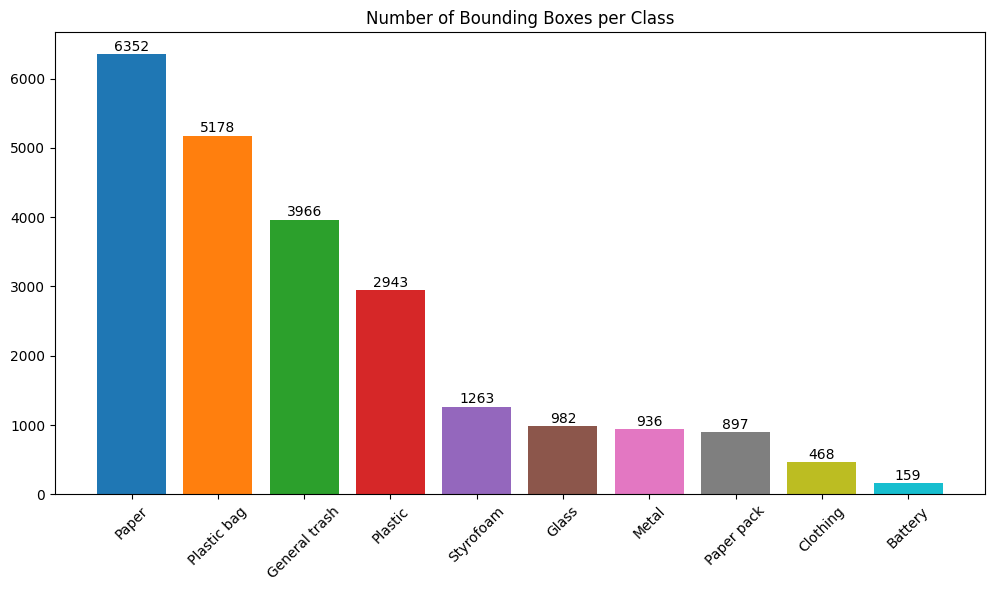

In [7]:
class_name = df['class_name'].value_counts()

bar_colors = [cmap(class_colors[class_name]) for class_name in class_name.index]

plt.figure(figsize=(12, 6))

plt.bar(class_name.index, class_name.values, color=bar_colors)
plt.title('Number of Bounding Boxes per Class')

plt.xticks(rotation=45)

for i, value in enumerate(class_name.values):
    plt.text(class_name.index[i], value + 5, f'{value:d}', ha='center', va='bottom')

### Object Count Distribution per Image

##### 아래 그래프는 각 이미지에 포함된 객체 수에 따른 분포를 나타냅니다. 이미지마다 객체(Bounding Box)의 개수가 달라지며, 이를 구간별로 나누어 시각화했습니다.

- **1~5개**의 객체를 포함한 이미지가 **3,645개**로 가장 많습니다.
- 그 다음으로 **6~10개**의 객체를 포함한 이미지가 **620개**로 뒤를 이으며, 나머지 구간들은 상대적으로 적은 수의 이미지를 차지하고 있습니다.
- **11~15개**, **16~20개** 구간에는 각각 **272개**, **162개**의 이미지가 포함되어 있으며, 21개 이상의 객체를 포함한 이미지는 매우 적습니다.

##### 이 분포는 대부분의 이미지가 적은 수의 객체를 가지고 있으며, 일부 이미지에만 다수의 객체가 포함되어 있음을 보여줍니다.

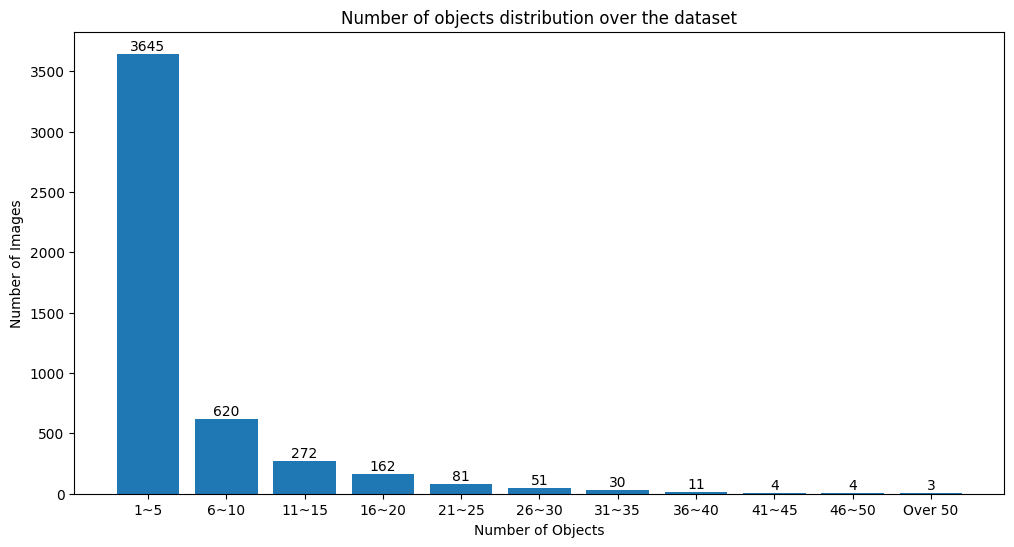

In [13]:
image_count = df['image_id'].value_counts()

bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, float('inf')]
labels = ['1~5', '6~10', '11~15', '16~20', '21~25', '26~30', '31~35', '36~40', '41~45', '46~50', 'Over 50']

count_range = pd.cut(image_count, bins=bins, labels=labels, right=True)
dic = count_range.value_counts().sort_index().to_dict()

fig, ax = plt.subplots(1,1, figsize = (12, 6))
ax.bar(dic.keys(), dic.values())
for i, value in enumerate(dic.values()):
    ax.text(i, value + 5, f'{value:d}', ha='center', va='bottom')

ax.set_title('Number of objects distribution over the dataset')
ax.set_ylabel('Number of Images')
ax.set_xlabel('Number of Objects')
plt.show()

Image ID: train/4197.jpg, Width: 1024, Height: 1024
Annotations (Count: 71):
  - Class Name: Plastic, Class ID: 5
  - Class Name: Paper, Class ID: 1
  - Class Name: General trash, Class ID: 0
  - Class Name: General trash, Class ID: 0
  - Class Name: Glass, Class ID: 4
  - Class Name: Paper pack, Class ID: 2
  - Class Name: Plastic bag, Class ID: 7
  - ...


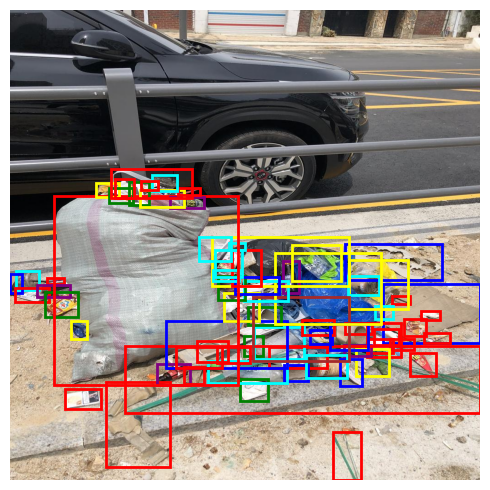

In [12]:
import matplotlib.pyplot as plt
from skimage import io
import os

# 특정 이미지 ID 지정
image_id_to_visualize = 'train/4197.jpg'  # 시각화할 이미지 ID

# 해당 이미지에 대한 데이터 필터링
annotations = df[df['image_id'] == image_id_to_visualize]

# 이미지 경로 설정
img_path = os.path.join(base_dir, image_id_to_visualize)  # base_dir이 정의되어 있다고 가정
I = io.imread(img_path)

# 클래스별 색상 매핑 정의
color_map = {
    "General trash": "red",
    "Paper": "blue",
    "Paper pack": "green",
    "Metal": "orange",
    "Glass": "purple",
    "Plastic": "cyan",
    "Styrofoam": "magenta",
    "Plastic bag": "yellow",
    "Battery": "black",
    "Clothing": "brown"
}

# 이미지 표시
plt.figure(figsize=(5, 5))
plt.imshow(I)
plt.axis('off')

# 각 주석에 대해 바운딩 박스 그리기
for _, ann in annotations.iterrows():
    x_min, y_min, x_max, y_max = ann['x_min'], ann['y_min'], ann['x_max'], ann['y_max']
    class_name = ann['class_name']
    
    # 클래스에 따라 색상 지정
    color = color_map.get(class_name, "black")  # 기본 색상은 검정색

    plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                        fill=False, edgecolor=color, linewidth=2))

# 이미지 및 주석 정보 출력
print(f"Image ID: {image_id_to_visualize}, Width: {I.shape[1]}, Height: {I.shape[0]}")
print(f"Annotations (Count: {len(annotations)}):")

# 주석을 최대 7개까지 출력하고 나머지는 생략
max_display = 7
for idx, (_, ann) in enumerate(annotations.iterrows()):
    if idx < max_display:
        print(f"  - Class Name: {ann['class_name']}, Class ID: {ann['class_id']}")
    else:
        print("  - ...")
        break  # 7개를 출력한 후 반복 종료

plt.tight_layout()
plt.show()

### Average Bounding Box Area per Class

##### 위 그래프는 각 클래스별 평균 바운딩 박스 면적을 나타냅니다. **Clothing** 클래스의 평균 바운딩 박스 면적이 다른 클래스에 비해 현저히 큰 것을 확인할 수 있습니다. 반면에, **Battery** 클래스는 상대적으로 작은 바운딩 박스 면적을 가집니다.

- **Clothing**: 가장 큰 평균 면적을 가지고 있음
- **Plastic Bag**, **Styrofoam**, **Paper**: 중간 크기의 면적을 가짐
- **Battery**, **Glass**: 작은 평균 면적을 가지고 있음

##### 이 데이터는 객체의 크기나 이미지 내에서 차지하는 영역이 클래스마다 다르다는 것을 나타내며, 다른 이미지 간에는 차지하는 영역이 큰 차이가 없지만, Clothing이 유독 면적이 크고, Battery는 비교적 작은 것을 확인할 수 있습니다.

/tmp/ipykernel_10966/437891307.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_area.index, y=avg_area.values, palette=bar_colors)


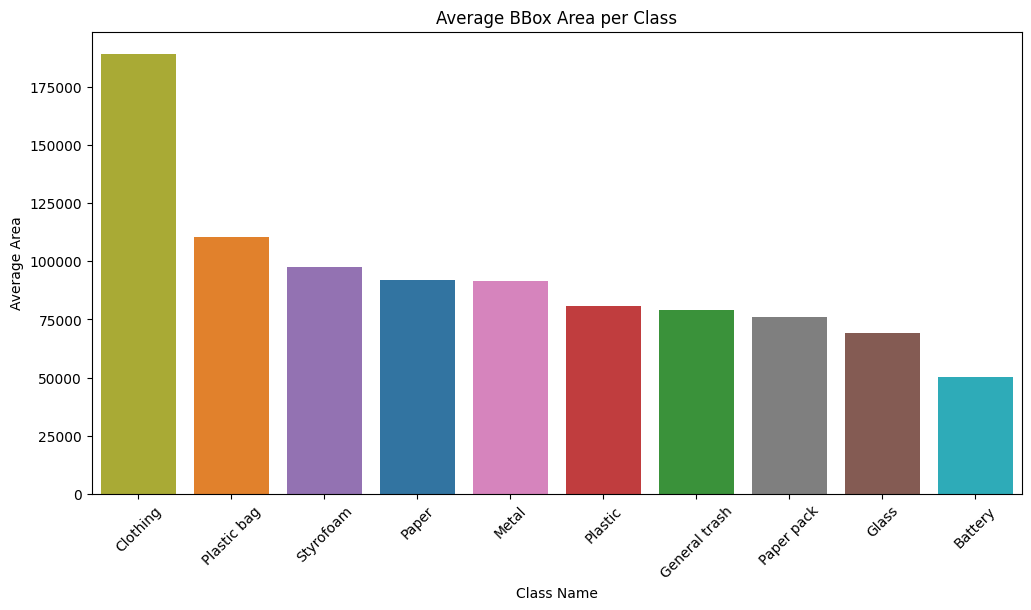

In [8]:
avg_area = df.groupby('class_name')['area'].mean().sort_values(ascending= False)

bar_colors = [cmap(class_colors[class_name]) for class_name in avg_area.index]

plt.figure(figsize=(12, 6))

sns.barplot(x=avg_area.index, y=avg_area.values, palette=bar_colors)
plt.xticks(rotation=45)
plt.title('Average BBox Area per Class')
plt.xlabel('Class Name')
plt.ylabel('Average Area')
plt.show()

### Heatmap과 평균 Bounding Box 크기의 시각화

##### 위의 시각화는 각 클래스별 Bounding Box의 위치와 크기를 나타낸 것입니다. 

1. **Heatmap**: 빨간색으로 표시된 부분은 해당 클래스에 대한 Bounding Box가 주로 위치하는 영역입니다. 색이 진할수록 해당 클래스의 Bounding Box가 그 위치에 더 자주 나타남을 의미합니다.
   
2. **평균 Bounding Box**: 파란색 사각형은 해당 클래스의 평균 Bounding Box 크기를 나타냅니다. 이는 각 클래스의 Bounding Box가 어느 정도 크기로 나타나는지를 시각적으로 보여줍니다.

이 시각화를 통해 특정 클래스의 Bounding Box가 이미지의 어느 부분에 주로 위치하며, 그 크기가 어느 정도 되는지를 파악할 수 있습니다

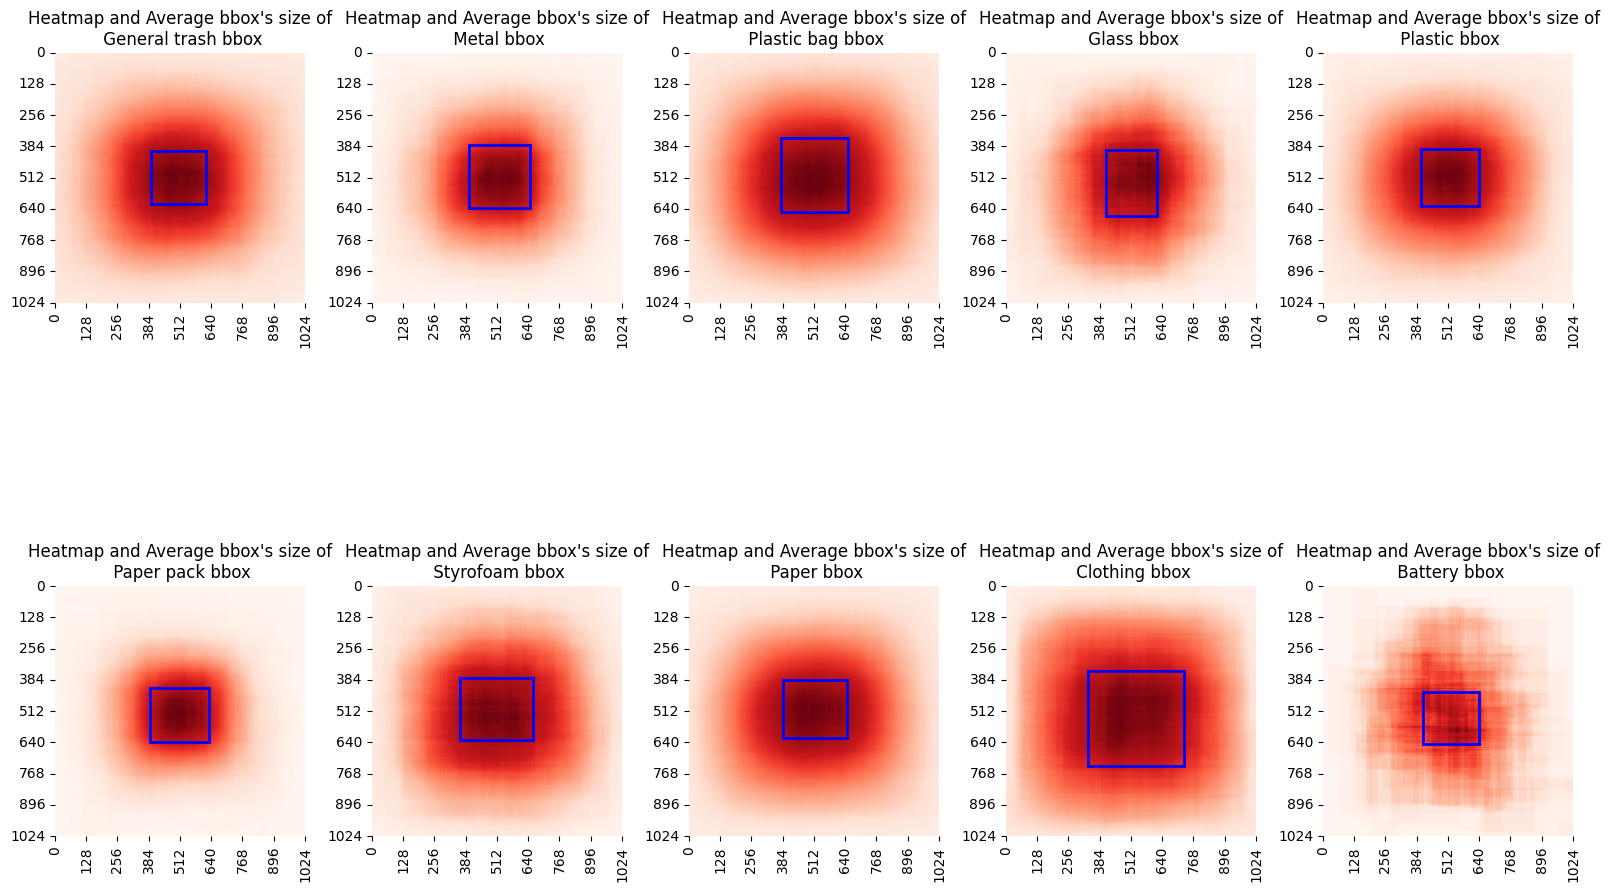

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(16, 12))

ax = ax.flatten()

for i, class_name in enumerate(df['class_name'].unique()):
    class_df = df[df['class_name'] == class_name]
    img_size = (1024, 1024)

    heatmap = np.zeros(img_size)

    for index, row in class_df.iterrows():
        x_min, y_min, x_max, y_max = int(row['x_min']), int(row['y_min']), int(row['x_max']), int(row['y_max'])
        
        heatmap[y_min:y_max, x_min:x_max] += 1

    sns.heatmap(heatmap, cmap='Reds', cbar=False, ax=ax[i])

    ax[i].set_aspect('equal')

    ax[i].add_patch(patches.Rectangle((np.mean(class_df['x_min']), np.mean(class_df['y_min'])), np.mean(class_df['x_max'])-np.mean(class_df['x_min']), 
                              np.mean(class_df['y_max'])-np.mean(class_df['y_min']), 
                              facecolor='none', edgecolor='b', linewidth=2))
    ax[i].set_xticks(np.arange(0, img_size[0]+1, 128))
    ax[i].set_xticklabels(np.arange(0, img_size[0]+1, 128))
    ax[i].set_yticks(np.arange(0, img_size[1]+1, 128))
    ax[i].set_yticklabels(np.arange(0, img_size[1]+1, 128))

    ax[i].set_title(f'Heatmap and Average bbox\'s size of\n {class_name} bbox')
plt.tight_layout()
plt.show()

### 클래스별 Bounding Box 종횡비 시각화

##### 아래 그림의 Class별 Bounding Box의 평균 종횡비를 나타냅니다. Bounding Box의 height 대비 width의 비율을 나타냅니다.

- **Styrofoam**과 **General trash**, **Battery** Class는 height 대비 width의 비율이 다른 클래스들보다 크며, 이는 해당 클래스의 Bounding Box가 평균적으로 width로 긴 경향이 있음을 의미합니다.
- **Glass**와 **Plastic Bag**은 거의 정사각형에 가까운 Bounding Box 형태를 가지며, height 대비 width 비율이 1.00에 가까운 것을 확인 할 수 있습니다.

##### 결론적으로 대부분 Class의 평균 종횡비는 width가 더 큰 것을 확인할 수 있고, Glass와 Plastic Bag은 평균적으로 정사각형에 가깝다고 볼 수 있습니다.

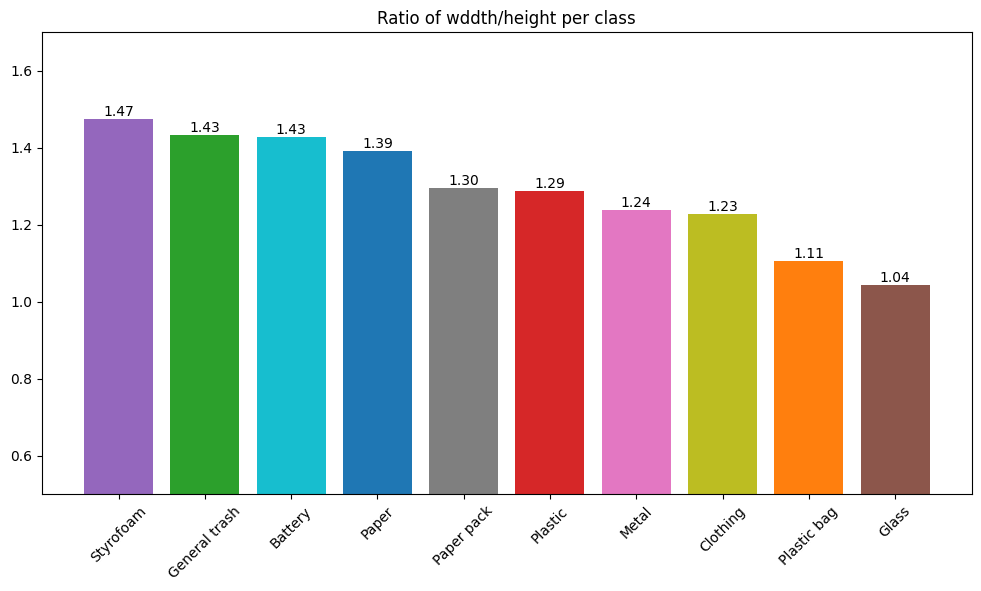

In [9]:
df['ratio'] = df['x_diff'] / df['y_diff']
ratio_df = df.groupby('class_name')['ratio'].mean().sort_values(ascending=False)

bar_colors = [cmap(class_colors[class_name]) for class_name in ratio_df.index]

plt.figure(figsize=(12, 6))
bars = plt.bar(ratio_df.index, ratio_df.values, color = bar_colors)

plt.ylim(0.5, 1.7)

plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.title('Ratio of wddth/height per class')
plt.show()

### 클래스 간 동시 등장 시각화

##### 아래 그림은 동일한 이미지에서 특정 클래스와 함께 등장하는 다른 클래스들의 빈도를 나타냅니다.

- 각 그래프는 특정 클래스를 기준으로, 해당 클래스가 다른 클래스들과 동시에 등장하는 빈도를 보여줍니다.
  
- **General trash**, **Plastic bag**, **Paper** 클래스는 다른 클래스들과 자주 함께 등장하는 경향을 보입니다. 특히 **Plastic**과 **Styrofoam**은 여러 클래스에서 공통적으로 자주 등장합니다.
  
- **Metal**, **Glass**, **Plastic** 클래스는 **General trash**와 함께 등장하는 빈도가 높습니다. 이는 다양한 쓰레기가 혼합된 상태로 배출되는 패턴을 반영합니다.
  
- **Battery** 클래스는 다른 클래스와 함께 등장하는 빈도가 상대적으로 낮습니다. 이는 배터리의 독립적인 처리 및 배출 특성을 나타냅니다.

##### 결론적으로, **General trash**와 **Plastic**은 다양한 클래스와 자주 혼합되며, **Battery**는 다른 클래스들과 비교적 독립적으로 등장하는 경향을 보입니다.

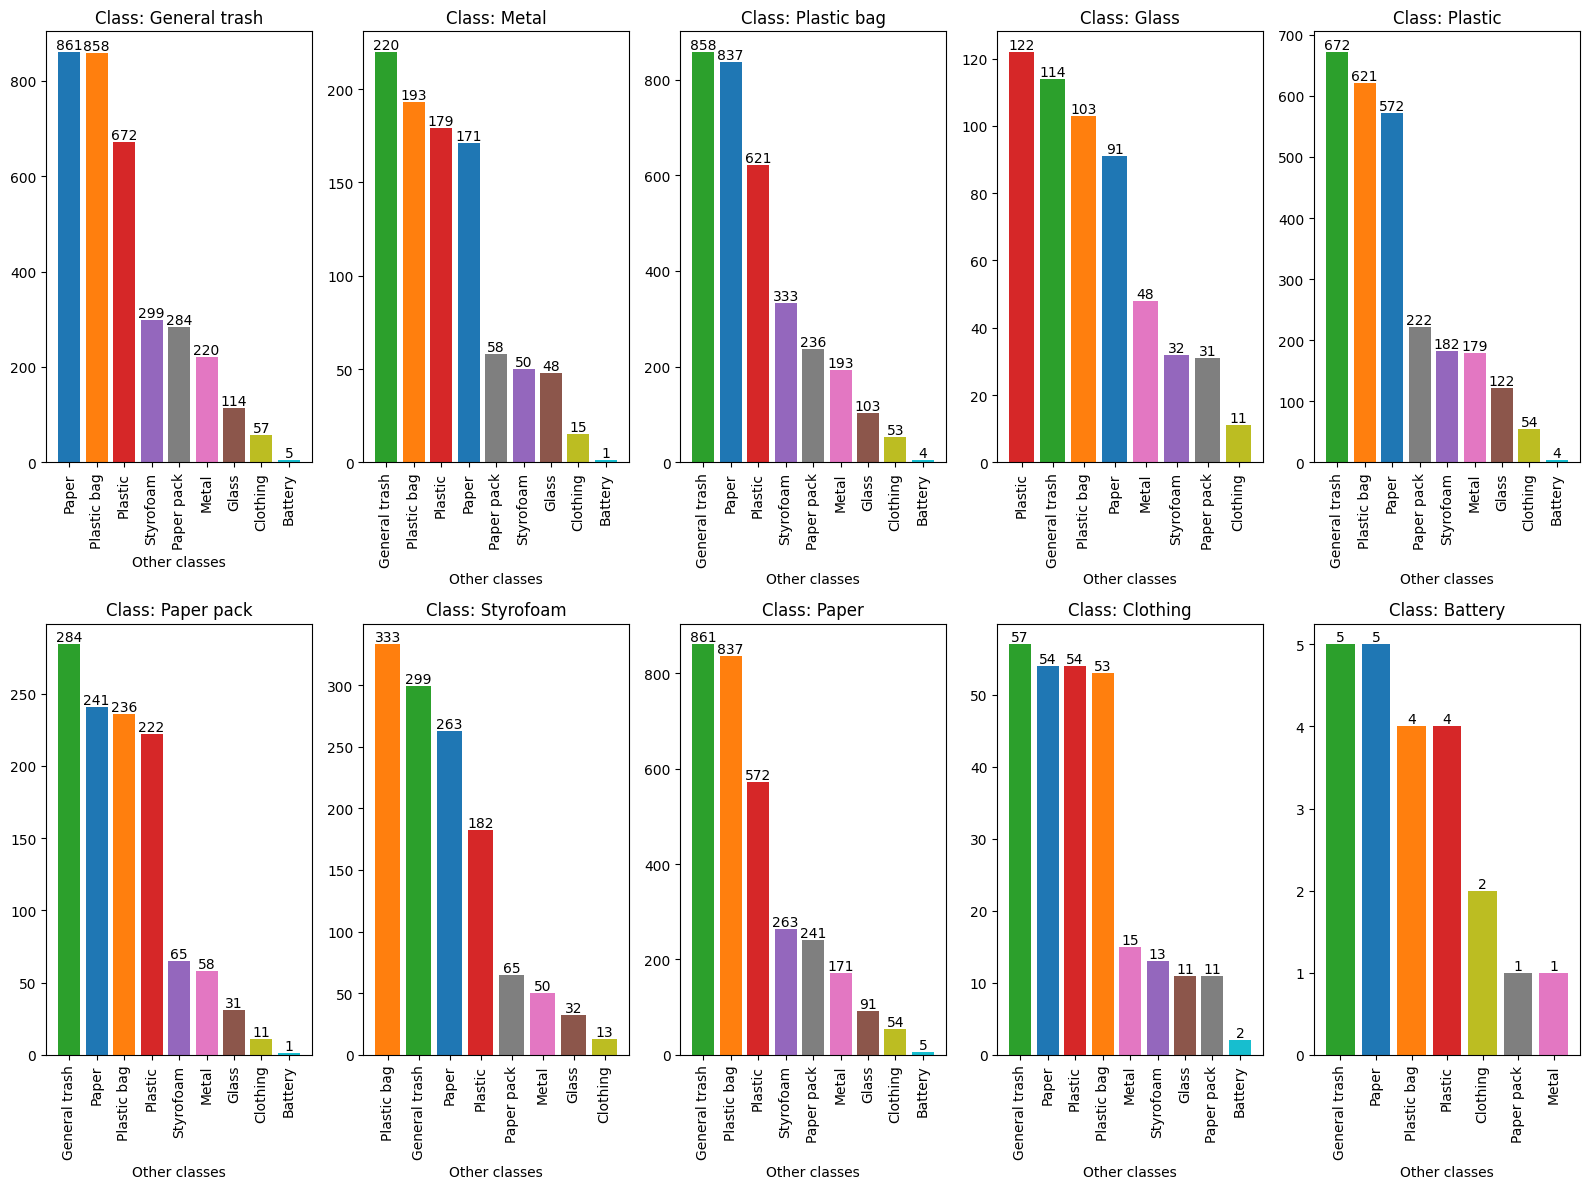

In [10]:
class_per_image = df.groupby('image_id')['class_name'].apply(lambda x: list(set(x)))
filt = [idx for idx, x in class_per_image.items() if len(x) >= 2]
over_two_class = class_per_image.loc[filt]

fig, ax = plt.subplots(2, 5, figsize=(16, 12))
ax = ax.flatten()

for i, class_name in enumerate(df['class_name'].unique()):
    over_two_class_in_target = over_two_class[[class_name in classes for classes in over_two_class]]

    other_classes = [c for classes in over_two_class_in_target for c in classes if c != class_name]
    other_class_count = pd.Series(other_classes).value_counts()

    bar_colors = [cmap(class_colors[class_name]) for class_name in other_class_count.index]

    bars = ax[i].bar(other_class_count.index, other_class_count.values, color = bar_colors)
    ax[i].set_title(f'Class: {class_name}')
    ax[i].set_xlabel('Other classes')
    ax[i].set_xticks(range(len(other_class_count.index)))
    ax[i].set_xticklabels(other_class_count.index, rotation=90)

    for bar in bars:
        yval = bar.get_height()
        ax[i].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:d}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
